NMF is best used with the fit_transform method, which returns the matrix W. The matrix H is stored into the fitted model in the components_ attribute; the method transform will decompose a new matrix X_new based on these stored components:

In [1]:
import numpy as np
X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
from sklearn.decomposition import NMF
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_
X_new = np.array([[1, 0], [1, 6.1], [1, 0], [1, 4], [3.2, 1], [0, 4]])
W_new = model.transform(X_new)

In [3]:
W

array([[ 0.        ,  0.46880684],
       [ 0.55699523,  0.3894146 ],
       [ 1.00331638,  0.41925352],
       [ 1.6733999 ,  0.22926926],
       [ 2.34349311,  0.03927954],
       [ 2.78981512,  0.06911798]])

In [4]:
W_new

array([[ 0.46677737,  0.        ],
       [ 0.        ,  1.66350401],
       [ 0.46677737,  0.        ],
       [ 0.        ,  1.17156989],
       [ 1.2277735 ,  0.29280011],
       [ 0.        ,  0.93701736]])

# testing sparse PCA implementation:

### Beta divergence loss functions

Automatically created module for IPython interactive environment


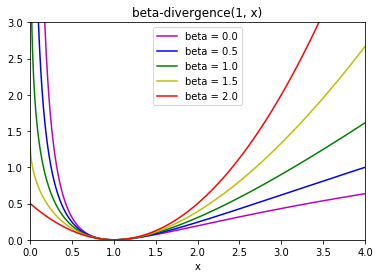

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition.nmf import _beta_divergence

print(__doc__)

x = np.linspace(0.001, 4, 1000)
y = np.zeros(x.shape)

colors = 'mbgyr'
for j, beta in enumerate((0., 0.5, 1., 1.5, 2.)):
    for i, xi in enumerate(x):
        y[i] = _beta_divergence(1, xi, 1, beta)
    name = "beta = %1.1f" % beta
    plt.plot(x, y, label=name, color=colors[j])

plt.xlabel("x")
plt.title("beta-divergence(1, x)")
plt.legend(loc=0)
plt.axis([0, 4, 0, 3])
plt.show()


Dataset consists of 400 faces
Extracting the top 6 Eigenfaces - PCA using randomized SVD...
done in 0.029s
Extracting the top 6 Non-negative components - NMF...
done in 0.203s
Extracting the top 6 Independent components - FastICA...
done in 0.105s
Extracting the top 6 Sparse comp. - MiniBatchSparsePCA...
done in 0.810s
Extracting the top 6 MiniBatchDictionaryLearning...
done in 0.630s
Extracting the top 6 Cluster centers - MiniBatchKMeans...
done in 0.066s
Extracting the top 6 Factor Analysis components - FA...
done in 0.075s


/Users/anvaribs/anaconda/lib/python3.5/site-packages/sklearn/decomposition/factor_analysis.py:228: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


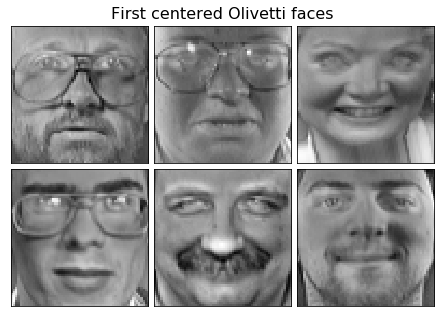

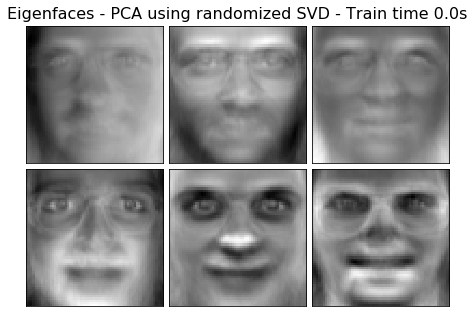

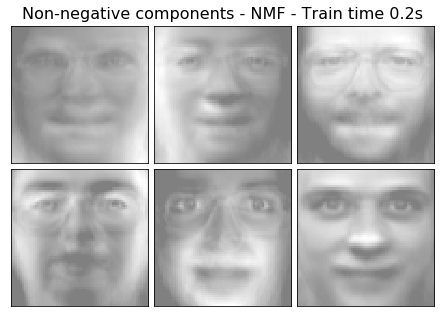

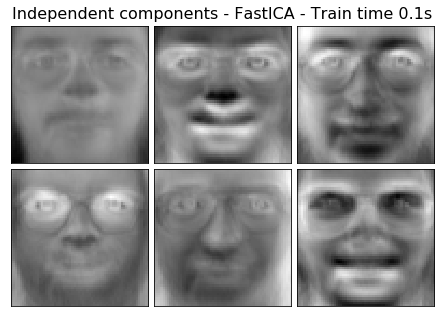

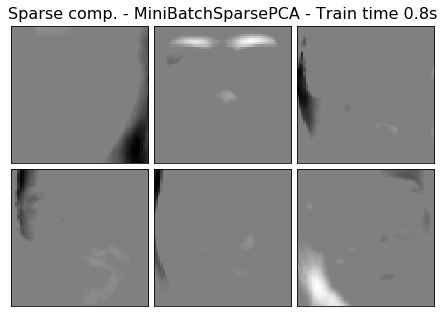

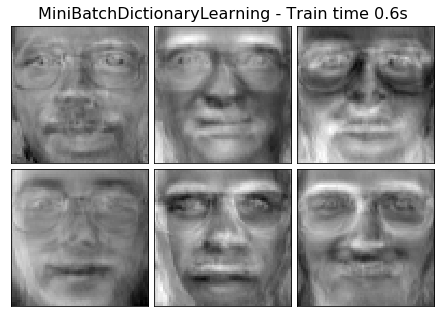

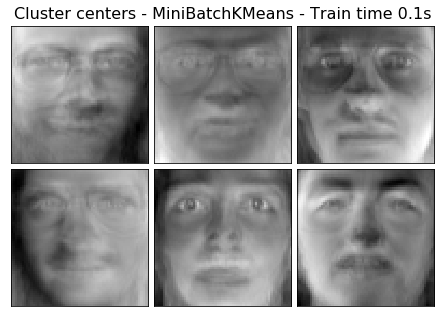

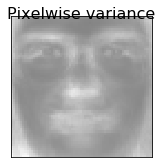

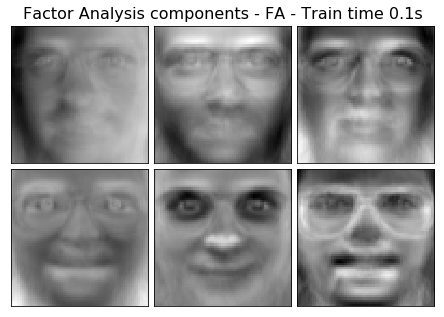

In [6]:
import logging
from time import time

from numpy.random import RandomState
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.cluster import MiniBatchKMeans
from sklearn import decomposition

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# #############################################################################
# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces = dataset.data

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)


def plot_gallery(title, images, n_col=n_col, n_row=n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

# #############################################################################
# List of the different estimators, whether to center and transpose the
# problem, and whether the transformer uses the clustering API.
estimators = [
    ('Eigenfaces - PCA using randomized SVD',
     decomposition.PCA(n_components=n_components, svd_solver='randomized',
                       whiten=True),
     True),

    ('Non-negative components - NMF',
     decomposition.NMF(n_components=n_components, init='nndsvda', tol=5e-3),
     False),

    ('Independent components - FastICA',
     decomposition.FastICA(n_components=n_components, whiten=True),
     True),

    ('Sparse comp. - MiniBatchSparsePCA',
     decomposition.MiniBatchSparsePCA(n_components=n_components, alpha=0.8,
                                      n_iter=100, batch_size=3,
                                      random_state=rng),
     True),

    ('MiniBatchDictionaryLearning',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng),
     True),

    ('Cluster centers - MiniBatchKMeans',
        MiniBatchKMeans(n_clusters=n_components, tol=1e-3, batch_size=20,
                        max_iter=50, random_state=rng),
     True),

    ('Factor Analysis components - FA',
     decomposition.FactorAnalysis(n_components=n_components, max_iter=2),
     True),
]


# #############################################################################
# Plot a sample of the input data

plot_gallery("First centered Olivetti faces", faces_centered[:n_components])

# #############################################################################
# Do the estimation and plot it

for name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()
    data = faces
    if center:
        data = faces_centered
    estimator.fit(data)
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    if hasattr(estimator, 'cluster_centers_'):
        components_ = estimator.cluster_centers_
    else:
        components_ = estimator.components_

    # Plot an image representing the pixelwise variance provided by the
    # estimator e.g its noise_variance_ attribute. The Eigenfaces estimator,
    # via the PCA decomposition, also provides a scalar noise_variance_
    # (the mean of pixelwise variance) that cannot be displayed as an image
    # so we skip it.
    if (hasattr(estimator, 'noise_variance_') and
            estimator.noise_variance_.ndim > 0):  # Skip the Eigenfaces case
        plot_gallery("Pixelwise variance",
                     estimator.noise_variance_.reshape(1, -1), n_col=1,
                     n_row=1)
    plot_gallery('%s - Train time %.1fs' % (name, train_time),
                 components_[:n_components])

plt.show()

## NMF vs LDA

This is an example of applying NMF and Latent Dirichlet Allocation on a corpus of documents and extract additive models of the topic structure of the corpus. The output is a list of topics, each represented as a list of terms (weights are not shown).


Non-negative Matrix Factorization is applied with two different objective functions: the Frobenius norm, and the generalized Kullback-Leibler divergence. The latter is equivalent to Probabilistic Latent Semantic Indexing.


The default parameters (n_samples / n_features / n_components) should make the example runnable in a couple of tens of seconds. You can try to increase the dimensions of the problem, but be aware that the time complexity is polynomial in NMF. In LDA, the time complexity is proportional to (n_samples * iterations).

In [7]:
from __future__ import print_function
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

print("Loading dataset...")
t0 = time()
dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data[:n_samples]
print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

# Fit the NMF model
print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

2017-12-14 16:44:16,931 INFO Downloading 20news dataset. This may take a few minutes.
2017-12-14 16:44:16,934 INFO Downloading dataset from https://ndownloader.figshare.com/files/5975967 (14 MB)


Loading dataset...
done in 79.162s.
Extracting tf-idf features for NMF...
done in 0.531s.
Extracting tf features for LDA...
done in 0.458s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.317s.

Topics in NMF model (Frobenius norm):
Topic #0: just people don think like know time good make way really say right ve want did ll new use years
Topic #1: windows use dos using window program os drivers application help software pc running ms screen files version card code work
Topic #2: god jesus bible faith christian christ christians does heaven sin believe lord life church mary atheism belief human love religion
Topic #3: thanks know does mail advance hi info interested email anybody looking card help like appreciated information send list video need
Topic #4: car cars tires miles 00 new engine insurance price condition oil power speed good 000 brake year models used bought
Topic #5: edu soon com send university internet mit ftp 